<a href="https://colab.research.google.com/github/NID123-CH/Pytorch-and-Image-Processing/blob/main/scratchpad_wandb_fruitclassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sriramr_apples_bananas_oranges_path = kagglehub.dataset_download('sriramr/apples-bananas-oranges')

print('Data source import complete.')


Data source import complete.


In [ ]:
sriramr_apples_bananas_oranges_path

'/root/.cache/kagglehub/datasets/sriramr/apples-bananas-oranges/versions/1'

In [ ]:
!ls /root/.cache/kagglehub/datasets/sriramr/apples-bananas-oranges/versions/1

original_data_set


In [ ]:
from pathlib import Path
path = Path('/root/.cache/kagglehub/datasets/sriramr/apples-bananas-oranges/versions/1')

In [ ]:
import torch
import torch.nn as nn

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights

In [ ]:
weights = ResNet18_Weights.IMAGENET1K_V1
weights

ResNet18_Weights.IMAGENET1K_V1

In [ ]:
resnet_model = resnet18(weights=weights)
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Freeze base model
resnet_model.requires_grad_(False)
next(iter(resnet_model.parameters())).requires_grad



False

In [ ]:
# Inspect head of the model
resnet_model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
# Change head of the model, adding a new hidden layer, take care of the
# matching with the chosen loss function
#resnet_model.fc = nn.Sequential(
#    nn.Linear(in_features=512, out_features=512),
#    nn.ReLU(),
#    nn.Linear(in_features=512, out_features=6),
#    nn.LogSoftmax() # this should be used alongside NLLoss()
#)
#loss_function = nn.NLLLoss()


# Change head of the model, adding a new hidden layer, take care of the
# matching with the chosen loss function
resnet_model.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=6), #Here, we omit the LogSoftmax()
    # because we are using CrossEntropyLoss, which already has a call to LogSoftmax()
)

loss_function = nn.CrossEntropyLoss()

In [ ]:
# The weights of the new fc layer are unfrozen
next(iter(resnet_model.fc.parameters()))

Parameter containing:
tensor([[-0.0403,  0.0314, -0.0425,  ...,  0.0411,  0.0101, -0.0389],
        [ 0.0072,  0.0062, -0.0052,  ...,  0.0336, -0.0156, -0.0435],
        [ 0.0207, -0.0139,  0.0377,  ...,  0.0232,  0.0009, -0.0037],
        ...,
        [ 0.0432, -0.0068, -0.0083,  ...,  0.0200, -0.0019,  0.0155],
        [ 0.0382, -0.0380, -0.0089,  ..., -0.0219, -0.0217,  0.0090],
        [-0.0372, -0.0167,  0.0322,  ..., -0.0237, -0.0156, -0.0350]],
       requires_grad=True)

## Define the optimizer



In [ ]:
from torch.optim import Adam, AdamW

optimizer = AdamW(resnet_model.parameters(), lr=0.003)

## Create a training config dictionary

In [ ]:
def get_training_config():
    config = {
        'learning_rate': 0.001,  # Lower learning rate for Adam
        'weight_decay': 1e-4,
        'epochs': 200,
        'min_lr': 1e-6  # Minimum learning rate for scheduler
    }
    return config

config = get_training_config()

## Define a learning rate scheduler

In [ ]:
# CosineAnnealingLR scheduler, this will change the learning rate across epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=config['epochs'],
        eta_min=config['min_lr']
    )


## Inspect the data transformations that come with the pretrained weights

In [ ]:
# This tells us how the images were preprocessed during the original training loop
pre_trans = weights.transforms()

In [ ]:
import os
os.listdir(path / 'original_data_set')

['rottenoranges',
 'freshoranges',
 'freshbanana',
 'rottenbanana',
 'rottenapples',
 'original_data_set',
 'freshapples']

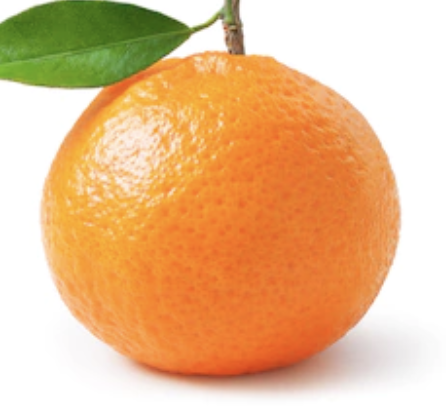

In [ ]:
from PIL import Image
imag = Image.open(path / 'original_data_set/freshoranges' / 'Screen Shot 2018-06-12 at 11.51.02 PM.png').convert('RGB')
imag

In [ ]:
pre_trans(imag).shape

torch.Size([3, 224, 224])

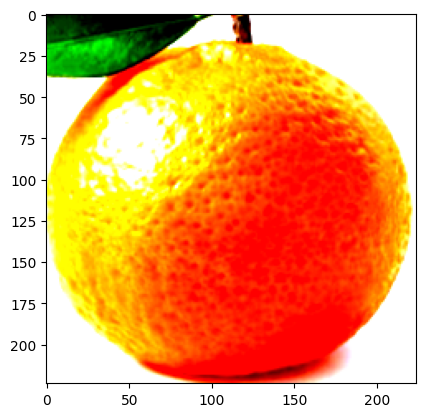

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(pre_trans(imag).permute(1, 2, 0));